In [2]:
# --- Setup and Libraries ---
import os, glob
import random
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
import opensmile
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [4]:
# --- Dataset Paths ---
data_paths = {
    "Healthy": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy",
    "Parkinson": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\parkinson"
}

# --- Tasks to include ---
required_tasks = ["B1", "B2", "FB1",
                  "VA1", "VA2", "VE1", "VE2", "VI1", "VI2",
                  "VO1", "VO2", "VU1", "VU2"]

# --- Collect files ---
paths = {"healthy": [], "parkinson": []}
for group, path in data_paths.items():
    all_group_files = glob.glob(os.path.join(path, '**', '*.wav'), recursive=True)
    filtered_files = [f for f in all_group_files if any(task in os.path.basename(f).upper() for task in required_tasks)]
    if "Healthy" in group:
        paths["healthy"].extend(filtered_files)
    elif "Parkinson" in group:
        paths["parkinson"].extend(filtered_files)

all_files = paths["healthy"] + paths["parkinson"]


In [6]:
def preprocess_audio(file_path, target_sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)
        sf.write(file_path, y, sr)
        return file_path
    except:
        return None

all_files_preprocessed = []
for f in tqdm(all_files, desc="Preprocessing audio files"):
    processed_file = preprocess_audio(f)
    if processed_file:
        all_files_preprocessed.append(processed_file)

print("Preprocessing complete samples:", len(all_files_preprocessed))


Preprocessing audio files:   0%|                                                               | 0/585 [00:00<?, ?it/s]D:\jupyter\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
Preprocessing audio files: 100%|█████████████████████████████████████████████████████| 585/585 [00:13<00:00, 43.33it/s]

Preprocessing complete samples: 585


File: C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy\AGNESE P\B1APGANRET55F170320171104.wav
Duration (sec): 101.35  | Sampling rate: 16000


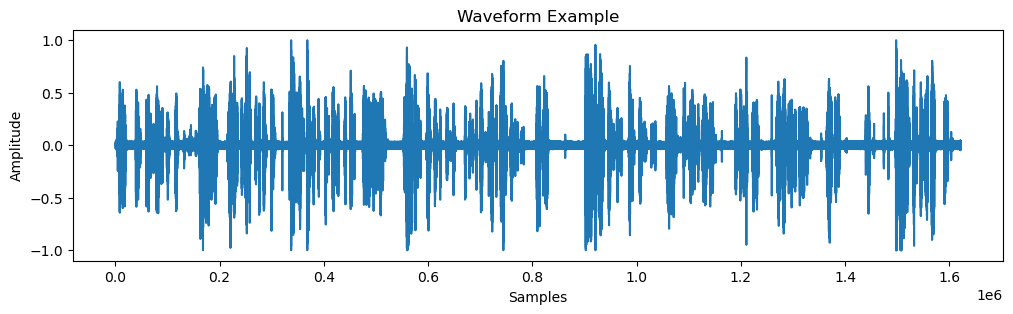

In [8]:
# --- Inspect a sample preprocessed file ---
sample_file = all_files_preprocessed[0]  # take first preprocessed audio
y, sr = librosa.load(sample_file, sr=None)  # load with original sampling rate

# Print file info
print("File:", sample_file)
print("Duration (sec):", round(len(y)/sr, 2), " | Sampling rate:", sr)

# Plot waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(y)
plt.title("Waveform Example")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [24]:
from scipy.stats import entropy 
def extract_nonlinear_features(y, sr=16000):
    """
    Extract strictly nonlinear features from a 1D audio signal.
    Includes:
    - Shannon entropy
    - Spectral entropy
    - Hjorth mobility
    - Hjorth complexity
    - Petrosian FD
    - Sevcik FD
    - Simplified Nonlinear FD
    - Temporal skewness
    - Temporal kurtosis
    """
    feats = {}
    try:
        y = y.astype(float)
        n = len(y)

        # Shannon entropy
        hist, _ = np.histogram(y, bins=100, density=True)
        feats["shannon_entropy"] = entropy(hist + 1e-8)

        # Spectral entropy
        psd = np.abs(np.fft.fft(y))**2
        psd_norm = psd / np.sum(psd)
        feats["spectral_entropy"] = entropy(psd_norm + 1e-8)

        # Hjorth parameters
        diff1 = np.diff(y)
        diff2 = np.diff(diff1)
        var_y = np.var(y)
        var_diff1 = np.var(diff1)
        var_diff2 = np.var(diff2)
        feats["hjorth_mobility"] = np.sqrt(var_diff1 / (var_y + 1e-8))
        feats["hjorth_complexity"] = np.sqrt(var_diff2 / (var_diff1 + 1e-8)) / (feats["hjorth_mobility"] + 1e-8)

        # Petrosian FD
        N_delta = np.sum(diff1[1:] * diff1[:-1] < 0)
        feats["petrosian_fd"] = np.log10(n) / (np.log10(n) + np.log10(n / (n + 0.4 * N_delta + 1e-8)))

        # Sevcik FD
        L = np.sum(np.sqrt(1 + diff1**2))
        feats["sevcik_fd"] = L / (2*(n-1))

        # Simplified Nonlinear FD (same as Petrosian)
        feats["nldfd"] = feats["petrosian_fd"]

        # Temporal skewness & kurtosis
        feats["temporal_skewness"] = pd.Series(y).skew()
        feats["temporal_kurtosis"] = pd.Series(y).kurt()

        return feats
    except Exception as e:
        print("Error extracting nonlinear features:", e)
        return None


In [26]:
# Organize preprocessed audio files by group
all_files_preprocessed_dict = {
    "Healthy": [f for f in all_files_preprocessed if "Healthy" in f or "healthy" in f],
    "Parkinson": [f for f in all_files_preprocessed if "Parkinson" in f or "parkinson" in f]
}

# Define label mapping
label_map = {"Healthy": 0, "Parkinson": 1}


In [28]:
from tqdm import tqdm

features_list = []
labels_list = []
files_list = []

for group, file_list in all_files_preprocessed_dict.items():
    for f in tqdm(file_list, desc=f"Processing {group}"):
        try:
            y, sr = librosa.load(f, sr=16000)
            feats = extract_nonlinear_features(y, sr)
            if feats is not None:
                features_list.append(feats)
                labels_list.append(label_map[group])
                files_list.append(f)
        except Exception as e:
            print(f"Error processing {f}: {e}")

# Convert to DataFrame
df_features = pd.DataFrame(features_list)
df_features["label"] = labels_list
df_features["filename"] = files_list

print("Nonlinear feature extraction complete!")
print("Shape of feature DataFrame:", df_features.shape)
print(df_features["label"].value_counts())


Processing Parkinson: 100%|██████████████████████████████████████████████████████████| 312/312 [00:28<00:00, 10.97it/s]

Nonlinear feature extraction complete!
Shape of feature DataFrame: (585, 11)
label
1    312
0    273
Name: count, dtype: int64


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# --- Keep only numeric columns for scaling ---
X_nl = df_features.select_dtypes(include=[np.number]).drop(columns=["label"])
y_nl = df_features["label"]

# --- Scale features ---
scaler_nl = StandardScaler()
X_nl_scaled = scaler_nl.fit_transform(X_nl)
print("Scaled nonlinear features mean:", X_nl_scaled.mean(), " | std:", X_nl_scaled.std())

# --- Convert back to DataFrame (optional) ---
df_nl_scaled = pd.DataFrame(X_nl_scaled, columns=X_nl.columns)
df_nl_scaled["label"] = y_nl.values
print(df_nl_scaled.head())

# --- Remove near-constant features (variance < 0.01) ---
selector_nl = VarianceThreshold(threshold=0.01)
X_nl_reduced = selector_nl.fit_transform(X_nl_scaled)

print("Original number of nonlinear features:", X_nl_scaled.shape[1])
print("Number of nonlinear features after variance thresholding:", X_nl_reduced.shape[1])


Scaled nonlinear features mean: -8.600738566000225e-15  | std: 1.0
   shannon_entropy  spectral_entropy  hjorth_mobility  hjorth_complexity  \
0        -1.343396          1.771342         1.353185           0.711980   
1        -0.417504          1.757442         1.687044           0.541647   
2        -0.767810          1.210684         1.999659           0.518775   
3         0.599465         -0.377258         0.138547          -0.050958   
4         1.114890         -1.364839        -0.290893          -0.027266   

   petrosian_fd  sevcik_fd     nldfd  temporal_skewness  temporal_kurtosis  \
0      1.701388  -0.235349  1.701388          -0.602421           0.809339   
1      1.154164   0.823773  1.154164          -0.325587           0.062158   
2      1.614608   0.561258  1.614608          -0.523944           0.289546   
3      0.592947   0.035874  0.592947           0.633204          -0.706777   
4      0.305515   0.607980  0.305515           0.833424          -0.809240   

   labe

In [48]:
import random

# Extract participant IDs from filenames (assuming folder structure .../Healthy/ParticipantID/file.wav)
df_features['participant'] = df_features['filename'].apply(lambda x: x.split(os.sep)[-2])

# Get unique participants per group
participants = {
    "Healthy": df_features[df_features['label']==0]['participant'].unique().tolist(),
    "Parkinson": df_features[df_features['label']==1]['participant'].unique().tolist()
}

# Split participants into train/test (80/20)
train_participants = []
test_participants = []

for group, plist in participants.items():
    random.seed(42)
    random.shuffle(plist)
    split_idx = int(0.8 * len(plist))
    train_participants += plist[:split_idx]
    test_participants += plist[split_idx:]

# Assign files to train/test based on participant
train_mask = df_features['participant'].isin(train_participants)
test_mask = df_features['participant'].isin(test_participants)

X = df_features.drop(columns=['label', 'filename', 'participant']).values
y = df_features['label'].values

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print("Speaker-independent split done!")
print("Train samples:", len(y_train))
print("Test samples:", len(y_test))


Speaker-independent split done!
Train samples: 455
Test samples: 130


In [50]:
from imblearn.over_sampling import SMOTE
import pandas as pd

print("Before SMOTE:\n", pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())


Before SMOTE:
 1    247
0    208
Name: count, dtype: int64
After SMOTE:
 0    247
1    247
Name: count, dtype: int64


In [52]:
# --- Traditional Machine Learning Models on SMOTE-balanced nonlinear features ---
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. SVM (Linear Kernel) ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train_bal, y_train_bal)
y_pred_svm = svm_clf.predict(X_test)

# --- 2. Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_clf.predict(X_test)

# --- 3. KNN ---
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_bal, y_train_bal)
y_pred_knn = knn_clf.predict(X_test)

# --- 4. Naive Bayes ---
nb_clf = GaussianNB()
nb_clf.fit(X_train_bal, y_train_bal)
y_pred_nb = nb_clf.predict(X_test)

# --- Classification Reports ---
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.80        65
           1       0.78      0.86      0.82        65

    accuracy                           0.81       130
   macro avg       0.81      0.81      0.81       130
weighted avg       0.81      0.81      0.81       130

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.82        65
           1       0.80      0.86      0.83        65

    accuracy                           0.82       130
   macro avg       0.82      0.82      0.82       130
weighted avg       0.82      0.82      0.82       130

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.69      0.76        65
           1       0.74      0.86      0.79        65

    accuracy                           0.78       130
   macro avg       0.79      0.78 

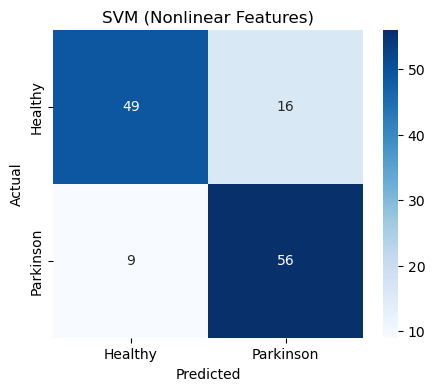

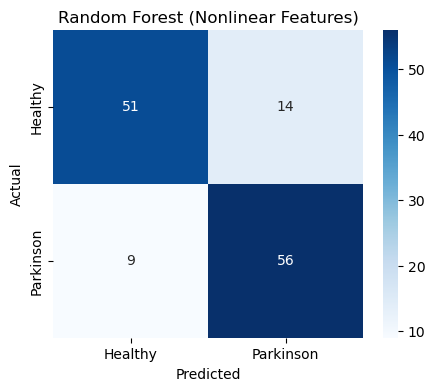

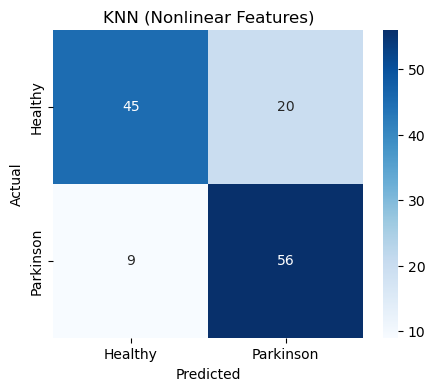

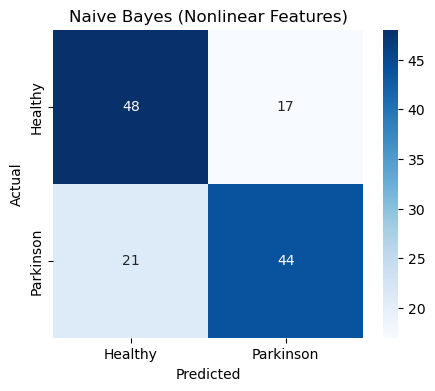

In [54]:
# --- Confusion Matrix Function ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinson"],
                yticklabels=["Healthy", "Parkinson"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# --- Plot confusion matrices ---
plot_confusion_matrix(y_test, y_pred_svm, "SVM (Nonlinear Features)")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest (Nonlinear Features)")
plot_confusion_matrix(y_test, y_pred_knn, "KNN (Nonlinear Features)")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes (Nonlinear Features)")

In [58]:
# --- Deep Learning with Nonlinear Features ---
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.utils import class_weight

# --- Feature Scaling ---
scaler_nl = StandardScaler()
X_train_scaled = scaler_nl.fit_transform(X_train_bal)  # SMOTE-balanced train set
X_test_scaled = scaler_nl.transform(X_test)           # Original test set

# --- Reshape for CNN+BiLSTM ---
timesteps = 1
feature_dim = X_train_scaled.shape[1] // timesteps

# truncate features to match timesteps * feature_dim
X_train_dl = X_train_scaled[:, :timesteps*feature_dim].reshape((X_train_scaled.shape[0], timesteps, feature_dim))
X_test_dl = X_test_scaled[:, :timesteps*feature_dim].reshape((X_test_scaled.shape[0], timesteps, feature_dim))

print("DL input shapes - Train:", X_train_dl.shape, " | Test:", X_test_dl.shape)
print("X_train_dl min/max:", X_train_dl.min(), " | X_test_dl min/max:", X_test_dl.max())



DL input shapes - Train: (494, 1, 9)  | Test: (130, 1, 9)
X_train_dl min/max: -5.356682043861457  | X_test_dl min/max: 9.755244390214822


In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

model_nl = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3), input_shape=(timesteps, feature_dim)),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3)),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')
])

model_nl.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


D:\jupyter\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# --- Class weights ---
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# --- Train model ---
history_nl = model_nl.fit(
    X_train_dl, y_train_bal,
    validation_data=(X_test_dl, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5379 - loss: 1.2720 - val_accuracy: 0.5000 - val_loss: 1.0302 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5641 - loss: 1.1808 - val_accuracy: 0.5000 - val_loss: 1.0288 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6653 - loss: 1.0632 - val_accuracy: 0.5000 - val_loss: 1.0279 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6944 - loss: 0.9609 - val_accuracy: 0.5000 - val_loss: 1.0266 - learning_rate: 1.0000e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6833 - loss: 0.9997 - val_accuracy: 0.5000 - val_loss: 1.0257 - learning_rate: 1.0000e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6841 - loss: 1.0271 - val_accuracy: 0.5000 - val_loss: 1.0249 - learning_rate: 1.0000e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.711

In [66]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 64)               │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 0, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 0, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 0, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 0, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 0, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 522,369 (1.99 MB)

 Trainable params: 521,217 (1.99 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Predict on test set ---
y_pred_prob = model_nl.predict(X_test_dl)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

# --- Classification report ---
print("Nonlinear Feature DL Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson"]))



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
Nonlinear Feature DL Classification Report:

              precision    recall  f1-score   support

     Healthy       0.90      0.69      0.78        65
   Parkinson       0.75      0.92      0.83        65

    accuracy                           0.81       130
   macro avg       0.82      0.81      0.81       130
weighted avg       0.82      0.81      0.81       130



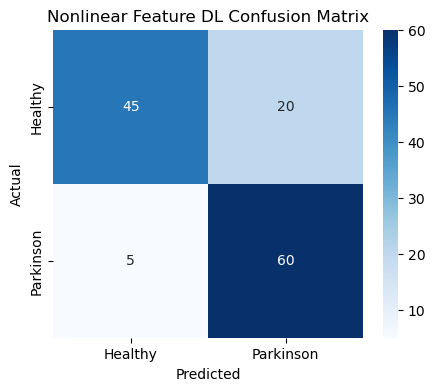

In [74]:
# --- Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.title("Nonlinear Feature DL Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# --- Compute accuracy and F1-score ---
from sklearn.metrics import accuracy_score, f1_score
test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)



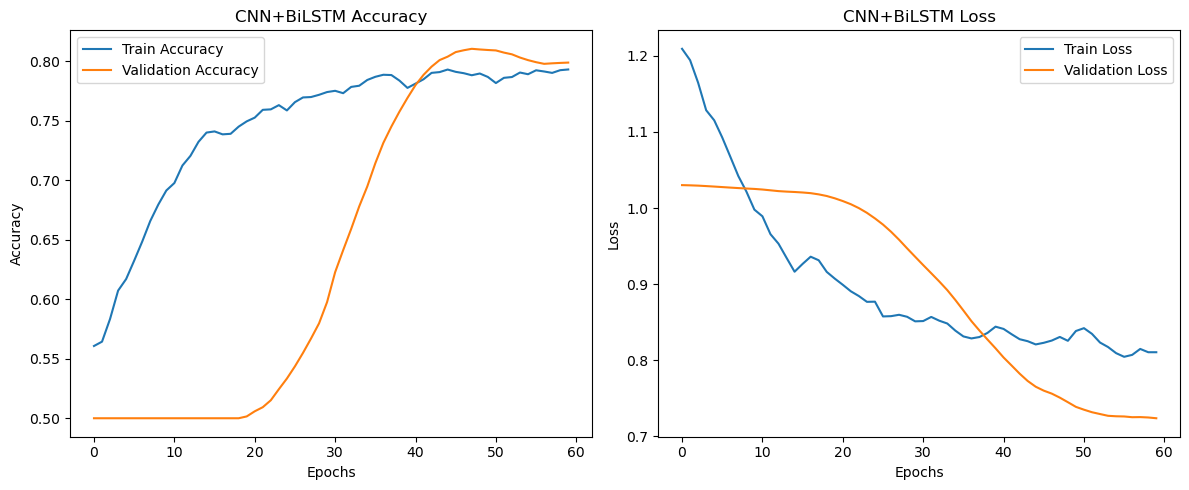

In [80]:
import matplotlib.pyplot as plt

# --- Smooth curves function ---
def smooth_curve(values, weight=0.8):
    smoothed = []
    last = values[0]
    for point in values:
        last = last * weight + (1 - weight) * point
        smoothed.append(last)
    return smoothed

# --- Smooth training curves ---
train_acc_smooth = smooth_curve(history_nl.history['accuracy'])
val_acc_smooth = smooth_curve(history_nl.history['val_accuracy'])
train_loss_smooth = smooth_curve(history_nl.history['loss'])
val_loss_smooth = smooth_curve(history_nl.history['val_loss'])

# --- Plot ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_acc_smooth, label='Train Accuracy')
plt.plot(val_acc_smooth, label='Validation Accuracy')
plt.title('CNN+BiLSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Loss
plt.subplot(1,2,2)
plt.plot(train_loss_smooth, label='Train Loss')
plt.plot(val_loss_smooth, label='Validation Loss')
plt.title('CNN+BiLSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [88]:
# --- Compute accuracy and F1-score ---
model_names = ['SVM', 'Random Forest', 'KNN', 'Naive Bayes', 'CNN+BiLSTM']
y_preds = [y_pred_svm, y_pred_rf, y_pred_knn, y_pred_nb, y_pred]

accuracy = [accuracy_score(y_test, y_pred) for y_pred in y_preds]
f1_scores = [f1_score(y_test, y_pred) for y_pred in y_preds]

# --- Print results ---
for i, name in enumerate(model_names):
    print(f"{name} - Test Accuracy: {accuracy[i]:.4f}, F1-score: {f1_scores[i]:.4f}")

SVM - Test Accuracy: 0.8077, F1-score: 0.8175
Random Forest - Test Accuracy: 0.8231, F1-score: 0.8296
KNN - Test Accuracy: 0.7769, F1-score: 0.7943
Naive Bayes - Test Accuracy: 0.7077, F1-score: 0.6984
CNN+BiLSTM - Test Accuracy: 0.8077, F1-score: 0.8276


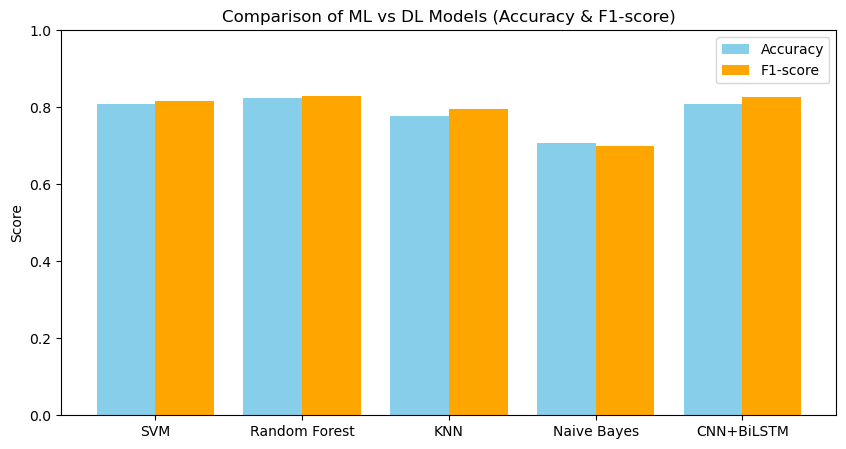

In [94]:
import matplotlib.pyplot as plt

x = range(len(model_names))
plt.figure(figsize=(10,5))

# Accuracy bars
plt.bar(x, accuracy, width=0.4, label='Accuracy', color='skyblue', align='center')

# F1-score bars
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score', color='orange', align='center')

plt.xticks([i + 0.2 for i in x], model_names)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparison of ML vs DL Models (Accuracy & F1-score)')
plt.legend()
plt.show()
